# Baseline forecaster



In forecasting modeling, a baseline serves as a basic, often simplistic model that acts as a fundamental reference for evaluating the performance of more complex models. It provides a baseline forecast using simple techniques that do not rely on sophisticated algorithms or extensive data analysis. Common examples of baseline strategies include:

+ Last Observed Value: Uses the last observed value as a forecast for all future periods.

+ Moving Average: In this technique, the average of the last few observations is calculated and used as a forecast for the next period. For example, a 3-period moving average would use the average of the last three observations.

+ Last Equivalent Date (Seasonal Naive Forecasting): Extends the concept of the last observed value by considering the corresponding period in the previous season (e.g., the same working day from the previous week) as the forecast for the current period.

The primary goal of establishing a baseline is to provide a benchmark against which the performance of more advanced predictive models can be evaluated. If the model does not outperform the baseline, it may indicate that there is a fundamental problem with the approach or that the added complexity is not justified by the available data. This underscores the importance of carefully evaluating the appropriateness of complex models relative to the simplicity and effectiveness of baseline models.

## ForecasterEquivalentDate

The <code>ForecasterEquivalentDate</code> class from `skforecast.recursive` allows the creation of a baseline forecast based on the concept of equivalent dates. In this context, an equivalent date is a historical date that has similar characteristics to the target date. The forecast for a given date is based on the value observed on the last *n* equivalent dates.
    
The behavior of the forecast is primarily controlled by two arguments:

+ `offset`: This parameter determines how many steps back in time to go to find the most recent equivalent date for the target period. When given as an integer, `offset` represents the number of steps to go back in time. For example, if the frequency of the time series is daily, `offset = 7` means that the most recent data similar to the target period is the value observed 7 days ago. Additionally, it is possible to use [Pandas DateOffsets](https://pandas.pydata.org/docs/reference/offset_frequency.html) to move forward a given number of valid dates. For example, `Bday(2)` can be used to move back two business days.

+ `n_offsets`: This parameter determines the number of equivalent dates to use in the prediction. If `n_offsets` is greater than 1, the values at the equivalent dates are aggregated using the specified aggregation function, `agg_func`. For example, if the frequency of the time series is daily, `offset = 7`, `n_offsets = 2`, and `agg_func = np.mean`, the predicted value will be the mean of the values observed 7 and 14 days ago.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<code>ForecasterEquivalentDate</code> is designed to integrate seamlessly with other functionality offered by skforecast, such as backtesting. This makes it easy to obtain the baseline for a given period.

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import set_dark_theme

fuel_consumption
----------------
Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.
Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and
Corporación de Derecho Público tutelada por el Ministerio para la Transición
Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas
Shape of the dataset: (644, 5)


date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1985-01-01 00:00:00  (n=60)


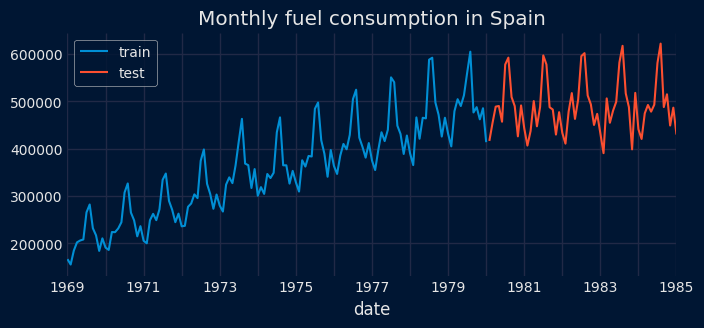

In [2]:
# Download data
# ======================================================================================
data = fetch_dataset('fuel_consumption')
data = data.rename(columns={'Gasolinas': 'litters'})
data.index.name = 'date'
data = data.loc[:'1985-01-01 00:00:00', 'litters']
display(data.head(4))

# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot
# ======================================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

## Create and train forecaster

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(months=12),
                 n_offsets = 2,
                 agg_func  = np.mean
             )

forecaster.fit(y=data_train)
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: months=12> 
Number of offsets: 2 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1980-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2025-03-07 11:18:15 
Last fit date: 2025-03-07 11:18:15 
Skforecast version: 0.15.0 
Python version: 3.12.9 
Forecaster id: None 

## Prediction

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data_test))
predictions.head(3)

1980-02-01    385298.35315
1980-03-01    472815.89325
1980-04-01    462944.81705
Freq: MS, Name: pred, dtype: float64

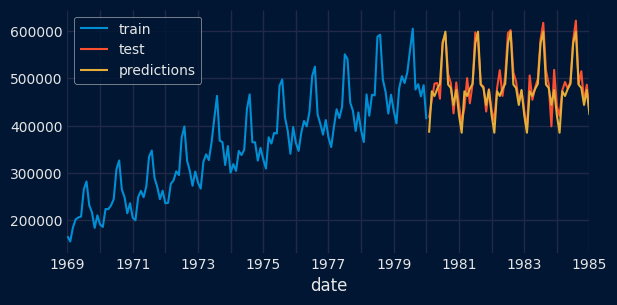

In [5]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
            
print(f"Test error (mse): {error_mse}")

Test error (mse): 446931887.96547604


## Backtesting

In [7]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 15,
         initial_train_size = len(data_train),
         refit              = True
     )

metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data,
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )

print("Backtest error:")
metric

  0%|          | 0/4 [00:00<?, ?it/s]

Backtest error:


,mean_absolute_error
0,18575.076906


In [8]:
# Backtesting predictions
# ==============================================================================
predictions.head(4)

,pred
1980-02-01,385298.35315
1980-03-01,472815.89325
1980-04-01,462944.81705
1980-05-01,477889.17740


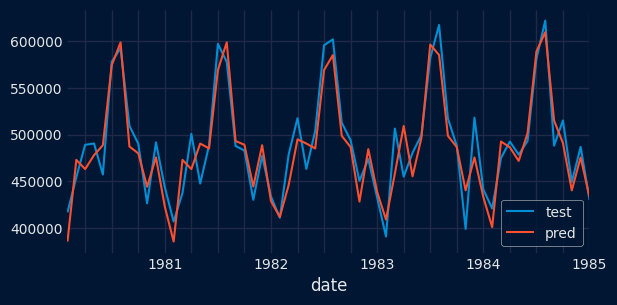

In [9]:
# Plot backtesting predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();